
# Stacking

*The following content is based on the scikit-learn tutorial "[Combine predictors using stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-download-auto-examples-ensemble-plot-stack-predictors-py)" by Guillaume Lemaitre and Maria Telenczuk.*

- It is sometimes tedious to find the model which will best perform on a given dataset. 

- Stacking provide an alternative by combining the outputs of several learners, without the need to choose a model specifically. 

- The performance of stacking is usually close to the best model and sometimes it can outperform the prediction performance of each individual model.

```{Note}
Stacking refers to a method to blend estimators. In this strategy, some estimators are individually fitted on some training data while a final estimator is trained using the stacked predictions of these base estimators.
```

- Here, we combine 3 learners (linear and non-linear) and use a ridge regressor to combine their outputs together.

- We compare the performance of each individual regressor with the
stacking strategy. 

- Stacking slightly improves the overall performance.

## Setup

In [34]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(display="diagram")
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate, cross_val_predict

# Data

- We will use `Ames Housing` which is a set of 1460 residential homes in Ames, Iowa, each described by 80 features. 

- We will use it to predict the final logarithmic price of the houses. 

- In this example we will use only 20 most interesting features chosen usin GradientBoostingRegressor() and limit number of entries (here we won't go into the details on how to select the most interesting features).

## Import


- The Ames housing dataset is not shipped with scikit-learn and therefore we will fetch it from `OpenML`

In [7]:
def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]

    X = X[features]
    X, y = shuffle(X, y, random_state=0)

    X = X[:600]
    y = y[:600]
    return X, np.log(y)

In [8]:
X, y = load_ames_housing()

## Preprocessing

- Before we can use Ames dataset we still need to do some preprocessing.

- First, we will select the categorical and numerical columns of the dataset to construct the first step of the pipeline.

In [10]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

In [12]:
cat_selector(X)


['HeatingQC',
 'Street',
 'Heating',
 'MasVnrType',
 'Foundation',
 'ExterQual',
 'Condition2',
 'GarageType',
 'HouseStyle',
 'MiscFeature']

In [13]:
num_selector(X)

['YrSold',
 'YearRemodAdd',
 'BsmtUnfSF',
 'MasVnrArea',
 'MSSubClass',
 'GarageCars',
 'OverallQual',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'MoSold']

- We will need to design preprocessing pipelines which depends on the
ending regressor. 

### Tree-based models pipeline

- Numerical data: can be treated as is by a tree-based model

- Categorical data: ordinal encoder will be sufficient

- Missing values: we need an imputer to handle missing values.

In [16]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

In [17]:
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

In [18]:
tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9488889d0>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb948888a00>)])

### Linear models pipeline

- Numerical data: need to be standardized for a linear model

- Categorical data: one-hot encode the categories

- Missing values: we need an imputer to handle missing values.

In [20]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")

In [21]:
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

In [22]:
linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)

linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9488889d0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb948888a00>)])

# Model Stacking

- Although we will make new pipelines with the processors which we wrote in
the previous section for the 3 learners, the final estimator `sklearn.linear_model.RidgeCV()` does not need preprocessing of the data as it will be fed with the already preprocessed output from the 3 learners.

## Lasso

In [30]:
lasso_pipeline = make_pipeline(
    linear_preprocessor, 
    LassoCV()
)

lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9488889d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb948888a00>)])),
                ('lassocv', LassoCV())])

## Random forest

In [31]:
rf_pipeline = make_pipeline(
    tree_preprocessor, 
    RandomForestRegressor(random_state=42)
)

rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9488889d0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb948888a00>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

## Gradient Boosting

In [32]:
gbdt_pipeline = make_pipeline(
    tree_preprocessor, 
    HistGradientBoostingRegressor(random_state=0)
)

gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9488889d0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb948888a00>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

## Stacking regressor

In [33]:
estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(
    estimators=estimators, 
    final_estimator=RidgeCV())

stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9488889d0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb9488889d0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb948888a00>)])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

## Measure and plot the results

- Now we can use Ames Housing dataset to make the predictions. 

- We check the performance of each individual predictor as well as of the stack of the
 regressors.

- The function ``plot_regression_results`` is used to plot the predicted and true targets.

In [37]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )

    ax.legend([extra], [scores], loc="upper left")
    
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)

- Make plot

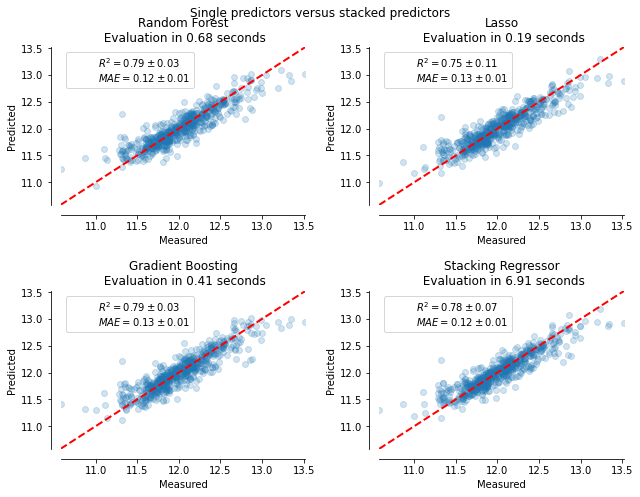

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

- The stacked regressor will combine the strengths of the different regressors.

- However, we also see that training the stacked regressor is much more computationally expensive.

